In [1]:
import cv2
import copy as c
import matplotlib.pyplot as plt
import os
from pathlib import Path

**Read data**

In [2]:
imgs = []
labels = []
for filename in os.listdir('./dataset/images/'):
    img = cv2.imread(os.path.join('./dataset/images/',filename))
    if img is not None:
            imgs.append(img)
            with open("./dataset/labels/{}.txt".format(Path(filename).stem),'r') as f:
                lines = f.readlines()
            labels.append(lines)

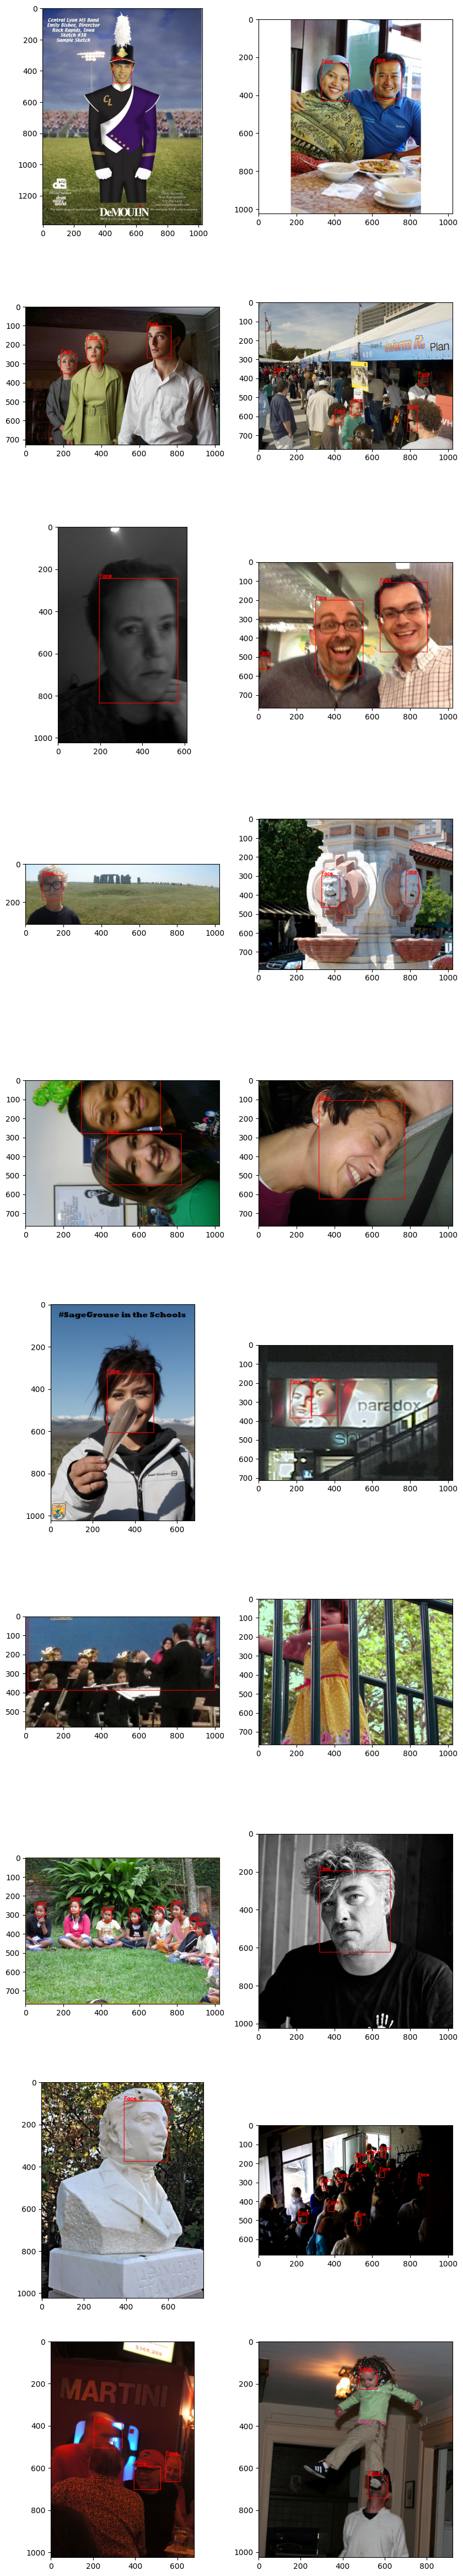

In [3]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 60))
columns = 2
rows = 10
imgs_labeled = c.deepcopy(imgs)
for i in range(0, columns*rows):
    img = cv2.cvtColor(imgs_labeled[i], cv2.COLOR_BGR2RGB)
    H, W, _ = img.shape
    for label in labels[i]:
        x,y,w,h = label.split(' ')[1:]
        x = int(float(x) * W)
        y = int(float(y) * H)
        w = int(float(w) * W)
        h = int(float(h) * H)
        cv2.rectangle(img, (x-w//2,y-h//2),(x+w//2,y+h//2),(255,0,0),2)
        cv2.putText(img, 'Face', (x-w//2, (y-h//2)-4), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

**Haar cascade training**

In [17]:
# import xmltodict
import json
import numpy as np
from random import randint

Positive images

In [42]:
# Helper
def convertToPixel(H, W, label):
    x,y,w,h = label.split(' ')[1:]
    x = int(float(x) * W)
    y = int(float(y) * H)
    w = int(float(w) * W)
    h = int(float(h) * H)
    return (x-w//2), (y-h//2), (x+w//2), (y+h//2)
    # return x,y,w,h

def convertTuple(tup):
    st = ' '.join(map(str, tup))
    return st

In [35]:
# # Write positive data mapping file
# f = open("pos.txt", "w")
# writeData = []
# for filename in os.listdir('./dataset/images/'):
#     img = cv2.imread(os.path.join('./dataset/images/', filename))
#     H, W, _ = img.shape
#     with open("./dataset/labels/{}.txt".format(Path(filename).stem),'r') as f1:
#         lines = f1.readlines()
#         faceRectangles = []
#         for line in list(lines):
#             x,y,w,h = convertToPixel(H, W, line)
#             faceRectangles.append(convertTuple((x,y,w-x,h-y)))
#             cv2.rectangle(img, (x, y), (w, h), (0,0,255), 2)
#     writeData.append('dataset/images/{} {} {}'.format(filename, len(list(lines)), " ".join(faceRectangles)))
#     cv2.imwrite('positive/{}'.format(filename), img)
# writeData = "\n".join(writeData)
# f.write(writeData)
# f.close()

Negative images

In [40]:
# Helper
def selectRandomRectangle(minH, maxH, minW, maxW):
    return randint(0, maxW), randint(0, maxH), randint(minW, maxW), randint(minH, maxH)

def moveCoordinates(maxH, maxW, coordinates):
    x,y,w,h = coordinates
    stepX = []
    stepY = []
    # calculate x
    if x == 0: # move right
        stepX.append(randint(int((w-x)/4), maxW - (w-x) - x))
    elif x+w > maxW: # move left
        stepX.append(randint(0, x) * -1)
    else:
        stepX.append(randint(int((w-x)/4), maxW - (w-x) - x))
        stepX.append(randint(0, x) * -1)

    # calculate y
    if y == 0: # move down
        stepY.append(randint(int((h-y)/4), maxH - (h-y) - y))
    elif y+h > maxH: # move left
        stepY.append(randint(0, y) * -1)
    else:
        stepY.append(randint(int((h-y)/4), maxH - (h-y) - y))
        stepY.append(randint(0, y) * -1)

    newX = x + (stepX[0] if len(stepX) == 1 else stepX[randint(0,1)])
    newY = y + (stepY[0] if len(stepY) == 1 else stepY[randint(0,1)])
    newW = newX + (w-x)
    newH = newY + (h-y)

    return newX, newY, newW, newH

In [45]:
# # create negative images
# f = open("neg.txt", "w")
# writeData = []
# for filename in os.listdir('./dataset/images/'):
#     img = cv2.imread(os.path.join('./dataset/images/', filename))
#     maxH, maxW, _ = img.shape
#     with open("./dataset/labels/{}.txt".format(Path(filename).stem),'r') as f1:
#         lines = f1.readlines()
#         for i in range(2):
#             img_temp = c.deepcopy(img)
#             faceRectangles = []
#             # print(lines)
#             for line in list(lines):
#                 x,y,w,h = convertToPixel(maxH, maxW, line)
#                 x,y,w,h = moveCoordinates(maxH, maxW, (x,y,w,h))
#                 # x,y,w,h = selectRandomRectangle(minH, maxH, minW, maxW)
#                 faceRectangles.append(convertTuple((x,y,w-x,h-y)))
#                 cv2.rectangle(img_temp, (x, y), (w, h), (0,0,255), 2)
#             writeData.append('dataset/images/{} {} {}'.format(filename, len(list(lines)), " ".join(faceRectangles)))
#             saveFileName = 'negative/{}_{}.{}'.format(Path(filename).stem, i, filename.split('.')[-1])
#             cv2.imwrite(saveFileName, img_temp)
# writeData = "\n".join(writeData)
# f.write(writeData)
# f.close()

In [55]:
f = open("neg.txt", "w")
writeData = []
for filename in os.listdir('./negative/'):
    writeData.append('negative/{}'.format(filename))
writeData = "\n".join(writeData)
f.write(writeData)
f.close()

Crop coordinates, gray scale & resize image (24x24)

In [4]:
import struct,array

In [2]:
# Helper
def divide_chunks(l, n, start=0): 
    # looping till length l 
    for i in range(start, len(l), n):  
        yield l[i:i + n]

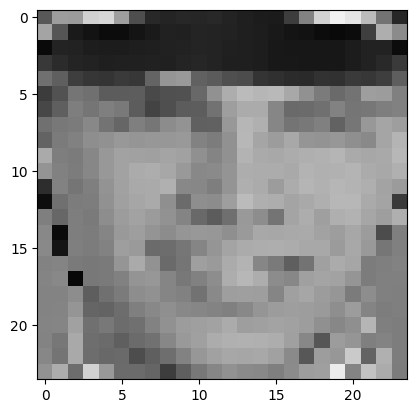

In [55]:
with open('pos.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        data = line.strip().split(' ')
        src = data[0]
        coor_len = data[1]
        chunks = divide_chunks(data, 4, 2)

        img = cv2.imread(src)
        grayScaleImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        for chunk in chunks:
            x = int(chunk[0])
            y = int(chunk[1])
            w = int(chunk[2])
            h = int(chunk[3])
            crop_img = grayScaleImg[y:y+h, x:x+w]
            resize_img = cv2.resize(crop_img, (24, 24))
        #     # Test
        #     plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))
        # break

In [46]:
# Using open cv
# positive vectors
# !C:/Users/nghoa/Desktop/projects/face-detection/opencv/build/x64/vc15/bin/opencv_createsamples.exe -info pos.txt -w 24 -h 24 -num 1000 -vec pos.vec

Info file name: neg.txt
Img file name: (NULL)
Vec file name: neg.vec
BG  file name: (NULL)
Num: 1000
BG color: 0
BG threshold: 80
Invert: FALSE
Max intensity deviation: 40
Max x angle: 1.1
Max y angle: 1.1
Max z angle: 0.5
Show samples: FALSE
Width: 24
Height: 24
Max Scale: -1
RNG Seed: 12345
Create training samples from images collection...
Done. Created 130 samples


neg.txt(49) : parse error


In [1]:
# Check vectors
def showvec(fn, width=24, height=24):
  f = open(fn,'rb')
  HEADERTYP = '<iihh' # img count, img size, min, max

  # read header
  imgcount,imgsize,_,_ = struct.unpack(HEADERTYP, f.read(12))
  img_vectors = []

  # for i in range(imgcount):
  for i in range(65):
    # print(i)
    img  = np.zeros((height,width),np.uint8)

    f.read(1) # read gap byte

    data = array.array('h')

    ###  buf = f.read(imgsize*2)
    ###  data.fromstring(buf)

    data.fromfile(f,imgsize)

    for r in range(height):
      for c in range(width):
        img[r,c] = data[r * width + c]

    img_vectors.append(cv2.cvtColor(img, cv2.COLOR_BGR2BGRA))
    # img = cv2.resize(img, (0,0), fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2BGRA))
    # break
    # cv2.imshow('vec_img',img)
    # k = 0xFF & cv2.waitKey(0)
    # if k == 27:         # esc to exit
    #   break

  fig = plt.figure(figsize=(10, 40))
  columns = 2
  rows = 1
  for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img_vectors[i], aspect='auto')
  plt.show()

In [2]:
showvec('pos.vec')

NameError: name 'struct' is not defined

Train cascade

In [64]:
# Using open cv
!C:/Users/nghoa/Desktop/projects/face-detection/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data cascade/ -vec pos.vec -bg neg.txt -numPos 65 -numNeg 10 -numStages 10 -w 24 -h 24

PARAMETERS:
cascadeDirName: cascade/
vecFileName: pos.vec
bgFileName: neg.txt
numPos: 65
numNeg: 10
numStages: 10
precalcValBufSize[Mb] : 1024
precalcIdxBufSize[Mb] : 1024
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.995
maxFalseAlarmRate: 0.5
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
mode: BASIC
Number of unique features given windowSize [24,24] : 162336

===== TRAINING 0-stage =====
<BEGIN
POS current samples: 1
POS current samples: 2
POS current samples: 3
POS current samples: 4
POS current samples: 5
POS current samples: 6
POS current samples: 7
POS current samples: 8
POS current samples: 9
POS current samples: 10
POS current samples: 11
POS current samples: 12
POS current samples: 13
POS current samples: 14
POS current samples: 15
POS current samples: 16
POS current samples: 17
POS current samples: 18
POS current samples: 19
POS current samples: 20
POS current samples: 21
POS current sample

Intergral Image

In [ ]:
def calculateIntergralImage(img):
    print(img.shape)
    return ''

In [ ]:
# width, height = 30, 40
# img = np.full(test_img_gray.shape, 60, np.uint8)
# cv2.putText(img, '8', (width//2-10, height//2+10), cv2.FONT_HERSHEY_DUPLEX, 1, 255, 2)

# np.savetxt('test_img.txt', img, fmt='%3d')

In [ ]:
# t_img =  calculateIntergralImage(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY))
# (t_img)

Test

In [ ]:
with open('haarcascade_frontalface_default.xml') as fd:
    doc = xmltodict.parse(fd.read())

In [ ]:
print(json.dumps(doc))

{"opencv_storage": {"cascade": {"@type_id": "opencv-cascade-classifier", "stageType": "BOOST", "featureType": "HAAR", "height": "24", "width": "24", "stageParams": {"maxWeakCount": "211"}, "featureParams": {"maxCatCount": "0"}, "stageNum": "25", "stages": {"_": [{"maxWeakCount": "9", "stageThreshold": "-5.0425500869750977e+00", "weakClassifiers": {"_": [{"internalNodes": "0 -1 0 -3.1511999666690826e-02", "leafValues": "2.0875380039215088e+00 -2.2172100543975830e+00"}, {"internalNodes": "0 -1 1 1.2396000325679779e-02", "leafValues": "-1.8633940219879150e+00 1.3272049427032471e+00"}, {"internalNodes": "0 -1 2 2.1927999332547188e-02", "leafValues": "-1.5105249881744385e+00 1.0625729560852051e+00"}, {"internalNodes": "0 -1 3 5.7529998011887074e-03", "leafValues": "-8.7463897466659546e-01 1.1760339736938477e+00"}, {"internalNodes": "0 -1 4 1.5014000236988068e-02", "leafValues": "-7.7945697307586670e-01 1.2608419656753540e+00"}, {"internalNodes": "0 -1 5 9.9371001124382019e-02", "leafValues"

Checking haar features

In [7]:
# import xmltodict
import json
import numpy as np
from random import randint

Positive images

In [42]:
# Helper
def convertToPixel(H, W, label):
    x,y,w,h = label.split(' ')[1:]
    x = int(float(x) * W)
    y = int(float(y) * H)
    w = int(float(w) * W)
    h = int(float(h) * H)
    return (x-w//2), (y-h//2), (x+w//2), (y+h//2)
    # return x,y,w,h

def convertTuple(tup):
    st = ' '.join(map(str, tup))
    return st

In [35]:
# # Write positive data mapping file
# f = open("pos.txt", "w")
# writeData = []
# for filename in os.listdir('./dataset/images/'):
#     img = cv2.imread(os.path.join('./dataset/images/', filename))
#     H, W, _ = img.shape
#     with open("./dataset/labels/{}.txt".format(Path(filename).stem),'r') as f1:
#         lines = f1.readlines()
#         faceRectangles = []
#         for line in list(lines):
#             x,y,w,h = convertToPixel(H, W, line)
#             faceRectangles.append(convertTuple((x,y,w-x,h-y)))
#             cv2.rectangle(img, (x, y), (w, h), (0,0,255), 2)
#     writeData.append('dataset/images/{} {} {}'.format(filename, len(list(lines)), " ".join(faceRectangles)))
#     cv2.imwrite('positive/{}'.format(filename), img)
# writeData = "\n".join(writeData)
# f.write(writeData)
# f.close()

Negative images

In [40]:
# Helper
def selectRandomRectangle(minH, maxH, minW, maxW):
    return randint(0, maxW), randint(0, maxH), randint(minW, maxW), randint(minH, maxH)

def moveCoordinates(maxH, maxW, coordinates):
    x,y,w,h = coordinates
    stepX = []
    stepY = []
    # calculate x
    if x == 0: # move right
        stepX.append(randint(int((w-x)/4), maxW - (w-x) - x))
    elif x+w > maxW: # move left
        stepX.append(randint(0, x) * -1)
    else:
        stepX.append(randint(int((w-x)/4), maxW - (w-x) - x))
        stepX.append(randint(0, x) * -1)

    # calculate y
    if y == 0: # move down
        stepY.append(randint(int((h-y)/4), maxH - (h-y) - y))
    elif y+h > maxH: # move left
        stepY.append(randint(0, y) * -1)
    else:
        stepY.append(randint(int((h-y)/4), maxH - (h-y) - y))
        stepY.append(randint(0, y) * -1)

    newX = x + (stepX[0] if len(stepX) == 1 else stepX[randint(0,1)])
    newY = y + (stepY[0] if len(stepY) == 1 else stepY[randint(0,1)])
    newW = newX + (w-x)
    newH = newY + (h-y)

    return newX, newY, newW, newH

In [45]:
# # create negative images
# f = open("neg.txt", "w")
# writeData = []
# for filename in os.listdir('./dataset/images/'):
#     img = cv2.imread(os.path.join('./dataset/images/', filename))
#     maxH, maxW, _ = img.shape
#     with open("./dataset/labels/{}.txt".format(Path(filename).stem),'r') as f1:
#         lines = f1.readlines()
#         for i in range(2):
#             img_temp = c.deepcopy(img)
#             faceRectangles = []
#             # print(lines)
#             for line in list(lines):
#                 x,y,w,h = convertToPixel(maxH, maxW, line)
#                 x,y,w,h = moveCoordinates(maxH, maxW, (x,y,w,h))
#                 # x,y,w,h = selectRandomRectangle(minH, maxH, minW, maxW)
#                 faceRectangles.append(convertTuple((x,y,w-x,h-y)))
#                 cv2.rectangle(img_temp, (x, y), (w, h), (0,0,255), 2)
#             writeData.append('dataset/images/{} {} {}'.format(filename, len(list(lines)), " ".join(faceRectangles)))
#             saveFileName = 'negative/{}_{}.{}'.format(Path(filename).stem, i, filename.split('.')[-1])
#             cv2.imwrite(saveFileName, img_temp)
# writeData = "\n".join(writeData)
# f.write(writeData)
# f.close()

In [55]:
f = open("neg.txt", "w")
writeData = []
for filename in os.listdir('./negative/'):
    writeData.append('negative/{}'.format(filename))
writeData = "\n".join(writeData)
f.write(writeData)
f.close()

Crop coordinates, gray scale & resize image (24x24)

In [4]:
import struct,array

In [2]:
# Helper
def divide_chunks(l, n, start=0): 
    # looping till length l 
    for i in range(start, len(l), n):  
        yield l[i:i + n]

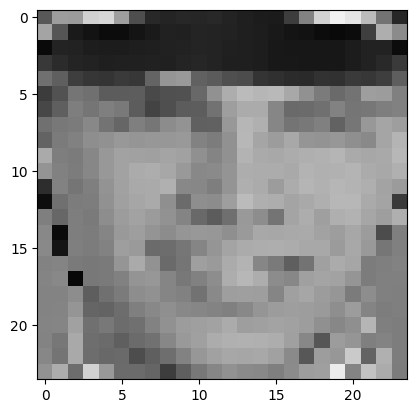

In [55]:
with open('pos.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        data = line.strip().split(' ')
        src = data[0]
        coor_len = data[1]
        chunks = divide_chunks(data, 4, 2)

        img = cv2.imread(src)
        grayScaleImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        for chunk in chunks:
            x = int(chunk[0])
            y = int(chunk[1])
            w = int(chunk[2])
            h = int(chunk[3])
            crop_img = grayScaleImg[y:y+h, x:x+w]
            resize_img = cv2.resize(crop_img, (24, 24))
        #     # Test
        #     plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))
        # break

In [46]:
# Using open cv
# positive vectors
# !C:/Users/nghoa/Desktop/projects/face-detection/opencv/build/x64/vc15/bin/opencv_createsamples.exe -info pos.txt -w 24 -h 24 -num 1000 -vec pos.vec

Info file name: neg.txt
Img file name: (NULL)
Vec file name: neg.vec
BG  file name: (NULL)
Num: 1000
BG color: 0
BG threshold: 80
Invert: FALSE
Max intensity deviation: 40
Max x angle: 1.1
Max y angle: 1.1
Max z angle: 0.5
Show samples: FALSE
Width: 24
Height: 24
Max Scale: -1
RNG Seed: 12345
Create training samples from images collection...
Done. Created 130 samples


neg.txt(49) : parse error


In [1]:
# Check vectors
def showvec(fn, width=24, height=24):
  f = open(fn,'rb')
  HEADERTYP = '<iihh' # img count, img size, min, max

  # read header
  imgcount,imgsize,_,_ = struct.unpack(HEADERTYP, f.read(12))
  img_vectors = []

  # for i in range(imgcount):
  for i in range(65):
    # print(i)
    img  = np.zeros((height,width),np.uint8)

    f.read(1) # read gap byte

    data = array.array('h')

    ###  buf = f.read(imgsize*2)
    ###  data.fromstring(buf)

    data.fromfile(f,imgsize)

    for r in range(height):
      for c in range(width):
        img[r,c] = data[r * width + c]

    img_vectors.append(cv2.cvtColor(img, cv2.COLOR_BGR2BGRA))
    # img = cv2.resize(img, (0,0), fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2BGRA))
    # break
    # cv2.imshow('vec_img',img)
    # k = 0xFF & cv2.waitKey(0)
    # if k == 27:         # esc to exit
    #   break

  fig = plt.figure(figsize=(10, 40))
  columns = 2
  rows = 1
  for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img_vectors[i], aspect='auto')
  plt.show()

In [2]:
showvec('pos.vec')

NameError: name 'struct' is not defined

Train cascade

In [64]:
# Using open cv
!C:/Users/nghoa/Desktop/projects/face-detection/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data cascade/ -vec pos.vec -bg neg.txt -numPos 65 -numNeg 10 -numStages 10 -w 24 -h 24

PARAMETERS:
cascadeDirName: cascade/
vecFileName: pos.vec
bgFileName: neg.txt
numPos: 65
numNeg: 10
numStages: 10
precalcValBufSize[Mb] : 1024
precalcIdxBufSize[Mb] : 1024
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.995
maxFalseAlarmRate: 0.5
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
mode: BASIC
Number of unique features given windowSize [24,24] : 162336

===== TRAINING 0-stage =====
<BEGIN
POS current samples: 1
POS current samples: 2
POS current samples: 3
POS current samples: 4
POS current samples: 5
POS current samples: 6
POS current samples: 7
POS current samples: 8
POS current samples: 9
POS current samples: 10
POS current samples: 11
POS current samples: 12
POS current samples: 13
POS current samples: 14
POS current samples: 15
POS current samples: 16
POS current samples: 17
POS current samples: 18
POS current samples: 19
POS current samples: 20
POS current samples: 21
POS current sample

Intergral Image

In [ ]:
def calculateIntergralImage(img):
    print(img.shape)
    return ''

In [ ]:
# width, height = 30, 40
# img = np.full(test_img_gray.shape, 60, np.uint8)
# cv2.putText(img, '8', (width//2-10, height//2+10), cv2.FONT_HERSHEY_DUPLEX, 1, 255, 2)

# np.savetxt('test_img.txt', img, fmt='%3d')

In [ ]:
# t_img =  calculateIntergralImage(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY))
# (t_img)

Test

In [ ]:
with open('haarcascade_frontalface_default.xml') as fd:
    doc = xmltodict.parse(fd.read())

In [ ]:
print(json.dumps(doc))

{"opencv_storage": {"cascade": {"@type_id": "opencv-cascade-classifier", "stageType": "BOOST", "featureType": "HAAR", "height": "24", "width": "24", "stageParams": {"maxWeakCount": "211"}, "featureParams": {"maxCatCount": "0"}, "stageNum": "25", "stages": {"_": [{"maxWeakCount": "9", "stageThreshold": "-5.0425500869750977e+00", "weakClassifiers": {"_": [{"internalNodes": "0 -1 0 -3.1511999666690826e-02", "leafValues": "2.0875380039215088e+00 -2.2172100543975830e+00"}, {"internalNodes": "0 -1 1 1.2396000325679779e-02", "leafValues": "-1.8633940219879150e+00 1.3272049427032471e+00"}, {"internalNodes": "0 -1 2 2.1927999332547188e-02", "leafValues": "-1.5105249881744385e+00 1.0625729560852051e+00"}, {"internalNodes": "0 -1 3 5.7529998011887074e-03", "leafValues": "-8.7463897466659546e-01 1.1760339736938477e+00"}, {"internalNodes": "0 -1 4 1.5014000236988068e-02", "leafValues": "-7.7945697307586670e-01 1.2608419656753540e+00"}, {"internalNodes": "0 -1 5 9.9371001124382019e-02", "leafValues"

Checking haar features